In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
%matplotlib inline
#from keras.preprocessing import image
import tensorflow.keras.applications.densenet as dense
import seaborn as sns

## Train image and Train data csv file directory

In [ ]:
train_img_dir = 'drive/MyDrive/Vision/data/train/'
train = pd.read_csv('drive/MyDrive/Vision/data/ISIC_2020_Training_GroundTruth_v2.csv')


## Load the data saved earlier after data augmentation using pickle library

In [ ]:
data=[]
labels=[]
import pickle
with open('drive/MyDrive/datax.pkl','rb') as f:
  data=pickle.load(f)

with open('drive/MyDrive/labelsx.pkl','rb') as f:
  labels=pickle.load(f)



Split the data into training testing and validation
Training data percentage = 70%
Validation data percentage= 10%
Testing data percentage= 10%

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,labels,test_size=0.3,random_state=42, shuffle=True)

x_test,x_val,y_test,y_val=train_test_split(x_test,y_test,test_size=0.5,random_state=42, shuffle=True)


"train_gen = pd.DataFrame({'image_dir': x_train, 'target': y_train})\nval_gen = pd.DataFrame({'image_dir': x_val, 'target': y_val})\ntest_gen=pd.DataFrame({'image_dir': x_test, 'target': y_test})\ntest_gen"

## Save Memory

In [ ]:
del data
del labels

In [ ]:
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from keras.metrics import AUC
from keras.activations import sigmoid
from keras import Model

## We used pretrained Xception model, add more layers to it and then train and validate it on our data.
## Layers added:
## Global Average Pooling Layers
## Dense Layers
## Dropout to prevent from overfitting
## Optimizer: Adam
## Loss: Binary CrossEntropy
## Activation: Sigmoid

In [ ]:
import tensorflow.keras.applications.xception as xcep
model = tf.keras.Sequential([
    xcep.Xception(
        input_shape=(128, 128, 3),
        weights='imagenet',
        include_top=False
    ),
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation= 'relu'), 
    layers.Dropout(0.2),
    layers.Dense(512, activation= 'relu'), 
    layers.Dropout(0.2), 
    layers.Dense(256, activation='relu'), 
    layers.Dropout(0.2), 
    layers.Dense(128, activation='relu'), 
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'), 
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])
    
model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0 

## We use early stopping to prevent from overfitting and save the weights

In [ ]:
nb_epochs = 25

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="drive/MyDrive/Vision/weightsxception.hdf5", verbose=1, save_best_only=True)

early_stop=EarlyStopping(monitor="val_loss",
                         patience=10,
                         mode="auto",)
#Learning_rate_reduction=ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=1,factor=0.5,min_lr=0.001)

callbacks=[early_stop,checkpointer]

## Training the model

In [ ]:
hist=model.fit(
    x_train,y_train, validation_data=[x_val,y_val],
    epochs=nb_epochs,
    
    callbacks=callbacks,
     )

Epoch 1/25
212/212 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.9304
Epoch 1: val_loss improved from inf to 0.07934, saving model to drive/MyDrive/Vision/weightsxception.hdf5
212/212 [==============================] - 64s 210ms/step - loss: 0.1926 - accuracy: 0.9304 - val_loss: 0.0793 - val_accuracy: 0.9828
Epoch 2/25
212/212 [==============================] - ETA: 0s - loss: 0.0779 - accuracy: 0.9742
Epoch 2: val_loss improved from 0.07934 to 0.06721, saving model to drive/MyDrive/Vision/weightsxception.hdf5
212/212 [==============================] - 44s 209ms/step - loss: 0.0779 - accuracy: 0.9742 - val_loss: 0.0672 - val_accuracy: 0.9917
Epoch 3/25
212/212 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9790
Epoch 3: val_loss did not improve from 0.06721
212/212 [==============================] - 42s 196ms/step - loss: 0.0864 - accuracy: 0.9790 - val_loss: 16.3744 - val_accuracy: 0.5196
Epoch 4/25
212/212 [==========================

## The model achieves an accuracy of 99.6% on training data 
## The model achieves an accuracy of 99.4% on validation data

## Getting predictions on the test data

In [ ]:
y_pred=model.predict(x_test)
for x in range(len(y_pred)):
  if y_pred[x]<0.5:
    y_pred[x]=0
  else:
    y_pred[x]=1

## Plotting the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[757,  12],
       [  1, 681]])

## Classification report for observing F1-Score, Precision, Recall

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       769
           1       0.98      1.00      0.99       682

    accuracy                           0.99      1451
   macro avg       0.99      0.99      0.99      1451
weighted avg       0.99      0.99      0.99      1451



## Loss Graph of Model

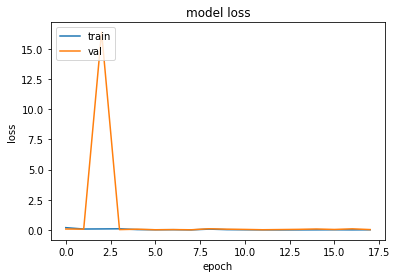

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()